# 09.2d: Black Hole Populations

**Compute degeneracy (population size) for each of the 13 black holes**

## What is Degeneracy?

**Degeneracy** = the number of tokens that share the exact same vector.

When we deduplicate vectors with `torch.unique()`, we collapse identical vectors into one representative. The `inverse_indices` tell us which original tokens map to which unique vector.

**Example:**
- Token IDs [100, 200, 300] all have identical vectors → degeneracy = 3
- Token ID [500] has a unique vector → degeneracy = 1 (singleton)

## The Question

BH #1 (the rogue) is isolated from the main cluster. **How many tokens does it contain?**

Prediction: 2 tokens (minimal black hole)

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
PAIRWISE_FILE = "neighborhood_pairwise_distances.safetensors"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"
INVERSE_KEY = "inverse_indices"

NEIGHBORHOOD_FILE = "cluster_neighborhood_r0.100.safetensors"
TOKEN_IDS_KEY = "token_ids"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading pairwise distances data...")
pairwise_data = load_file(data_dir / PAIRWISE_FILE)
unique_vectors = pairwise_data[UNIQUE_VECTORS_KEY]
unique_token_ids = pairwise_data[UNIQUE_TOKEN_IDS_KEY]
inverse_indices = pairwise_data[INVERSE_KEY]

n_unique = len(unique_vectors)
print(f"  Unique vectors: {n_unique:,}")
print()

print("Loading neighborhood token IDs...")
neighborhood_data = load_file(data_dir / NEIGHBORHOOD_FILE)
all_token_ids = neighborhood_data[TOKEN_IDS_KEY]
n_total = len(all_token_ids)
print(f"  Total tokens in neighborhood: {n_total:,}")
print()

print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
print()

print("✓ Data loaded")

Loading pairwise distances data...
  Unique vectors: 499

Loading neighborhood token IDs...
  Total tokens in neighborhood: 2,586

Loading black hole mask...

✓ Data loaded


## Compute Degeneracy for All Unique Vectors

In [4]:
print("Computing degeneracy (population) for each unique vector...\n")

# Degeneracy: how many tokens map to each unique vector
degeneracy = torch.bincount(inverse_indices)

print(f"Degeneracy statistics (all {n_unique:,} unique vectors):")
print(f"  Min:    {degeneracy.min().item()}")
print(f"  Max:    {degeneracy.max().item()}")
print(f"  Mean:   {degeneracy.float().mean().item():.1f}")
print(f"  Median: {degeneracy.float().median().item():.0f}")
print()

# How many singletons vs degenerate vectors?
n_singletons = (degeneracy == 1).sum().item()
n_degenerate = (degeneracy > 1).sum().item()

print(f"Breakdown:")
print(f"  Singletons (degeneracy = 1):  {n_singletons:,} ({100 * n_singletons / n_unique:.1f}%)")
print(f"  Degenerate (degeneracy > 1):  {n_degenerate:,} ({100 * n_degenerate / n_unique:.1f}%)")
print()
print("✓ Degeneracy computed")

Computing degeneracy (population) for each unique vector...

Degeneracy statistics (all 499 unique vectors):
  Min:    1
  Max:    814
  Mean:   5.2
  Median: 1

Breakdown:
  Singletons (degeneracy = 1):  486 (97.4%)
  Degenerate (degeneracy > 1):  13 (2.6%)

✓ Degeneracy computed


## Identify Black Hole Vectors and Their Populations

In [5]:
print("Identifying black hole vectors and their populations...\n")

# Which unique vectors are black holes?
is_bh = black_hole_mask[unique_token_ids]
bh_indices = torch.where(is_bh)[0]
n_bh = len(bh_indices)

print(f"Black holes in neighborhood: {n_bh}")
print()

# Extract their degeneracies
bh_degeneracies = degeneracy[bh_indices]

print(f"Black hole population statistics:")
print(f"  Min:    {bh_degeneracies.min().item()} tokens")
print(f"  Max:    {bh_degeneracies.max().item()} tokens")
print(f"  Mean:   {bh_degeneracies.float().mean().item():.1f} tokens")
print(f"  Median: {bh_degeneracies.float().median().item():.0f} tokens")
print(f"  Total:  {bh_degeneracies.sum().item()} tokens across all {n_bh} black holes")
print()
print("✓ Black hole populations computed")

Identifying black hole vectors and their populations...

Black holes in neighborhood: 13

Black hole population statistics:
  Min:    2 tokens
  Max:    814 tokens
  Mean:   161.5 tokens
  Median: 6 tokens
  Total:  2100 tokens across all 13 black holes

✓ Black hole populations computed


## Population Table: All 13 Black Holes

In [6]:
print("="*80)
print("BLACK HOLE POPULATIONS")
print("="*80)
print()
print("BH # | Global Index | Population | Representative Token ID")
print("-" * 80)

for i, idx in enumerate(bh_indices):
    idx = idx.item()
    pop = degeneracy[idx].item()
    token_id = unique_token_ids[idx].item()
    
    marker = "  ← ROGUE" if i == 1 else ""  # BH #1 is the rogue
    
    print(f"  {i:2d} |    {idx:4d}      |   {pop:5d}    | {token_id:8d}{marker}")

print()
print(f"Total tokens in black holes: {bh_degeneracies.sum().item():,}")
print()
print("="*80)

BLACK HOLE POPULATIONS

BH # | Global Index | Population | Representative Token ID
--------------------------------------------------------------------------------
   0 |     238      |      10    |   119349
   1 |     240      |       4    |   136831  ← ROGUE
   2 |     241      |       5    |   132383
   3 |     245      |     306    |      124
   4 |     263      |       4    |   135619
   5 |     266      |     814    |    80091
   6 |     267      |     228    |   124350
   7 |     272      |       3    |   126775
   8 |     282      |       3    |      180
   9 |     283      |       2    |   126816
  10 |     284      |     704    |      125
  11 |     293      |      11    |   123939
  12 |     294      |       6    |   126268

Total tokens in black holes: 2,100



## Focus on BH #1 (The Rogue)

In [7]:
print("\n" + "="*80)
print("BH #1 (THE ROGUE) - DETAILED ANALYSIS")
print("="*80)
print()

rogue_local_idx = 1
rogue_global_idx = bh_indices[rogue_local_idx].item()
rogue_population = degeneracy[rogue_global_idx].item()
rogue_rep_token = unique_token_ids[rogue_global_idx].item()

print(f"BH #1 (Rogue Black Hole):")
print(f"  Global index in unique vectors: {rogue_global_idx}")
print(f"  Representative token ID:        {rogue_rep_token}")
print(f"  Population:                     {rogue_population} tokens")
print()

# Find all token IDs that map to this black hole
maps_to_rogue = (inverse_indices == rogue_global_idx)
rogue_token_ids = all_token_ids[maps_to_rogue]

print(f"All token IDs in BH #1:")
for i, tid in enumerate(rogue_token_ids):
    print(f"  Token {i+1}: {tid.item()}")
print()

# Prediction check
if rogue_population == 2:
    print("  ✓ PREDICTION CONFIRMED: Population = 2")
    print("    The rogue is a minimal black hole (binary degeneracy)")
elif rogue_population == 1:
    print("  ⚠ Population = 1 (singleton)")
    print("    Not actually a black hole, just isolated!")
else:
    print(f"  ○ Population = {rogue_population}")
    print(f"    {'Larger' if rogue_population > 2 else 'Smaller'} than predicted")

print()
print("="*80)


BH #1 (THE ROGUE) - DETAILED ANALYSIS

BH #1 (Rogue Black Hole):
  Global index in unique vectors: 240
  Representative token ID:        136831
  Population:                     4 tokens

All token IDs in BH #1:
  Token 1: 136831
  Token 2: 138068
  Token 3: 138072
  Token 4: 139278

  ○ Population = 4
    Larger than predicted



## Population Distribution Visualization

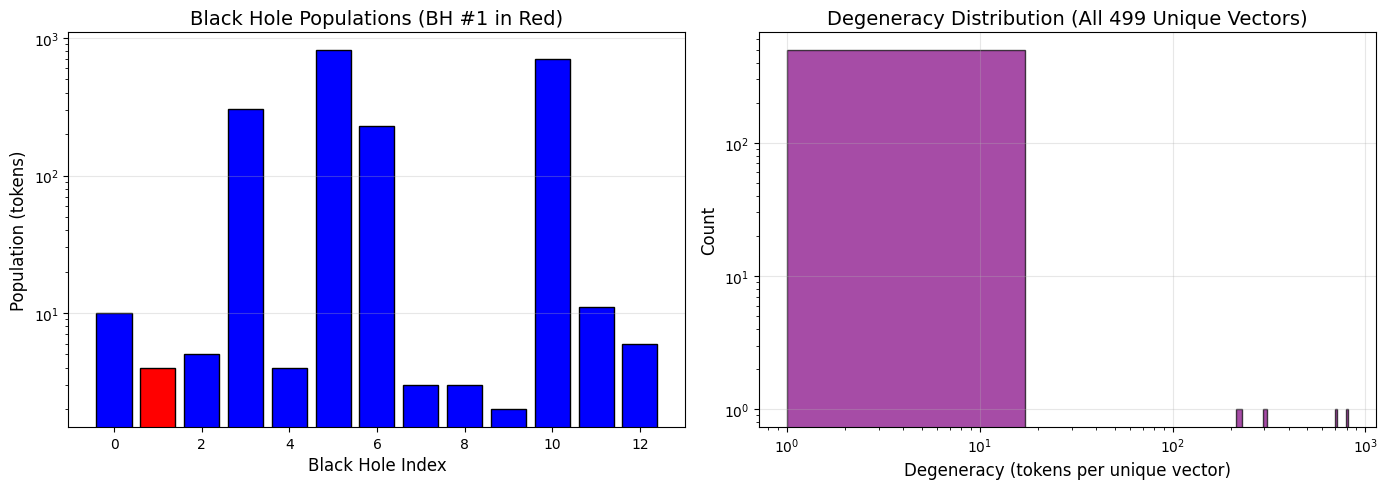

✓ Visualization complete


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: Black hole populations (bar chart)
ax = axes[0]
colors = ['red' if i == 1 else 'blue' for i in range(n_bh)]
ax.bar(range(n_bh), bh_degeneracies.cpu().numpy(), color=colors, edgecolor='black')
ax.set_xlabel('Black Hole Index', fontsize=12)
ax.set_ylabel('Population (tokens)', fontsize=12)
ax.set_title('Black Hole Populations (BH #1 in Red)', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: All degeneracies (histogram)
ax = axes[1]
ax.hist(degeneracy.cpu().numpy(), bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('Degeneracy (tokens per unique vector)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Degeneracy Distribution (All {n_unique:,} Unique Vectors)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary

In [9]:
print("="*80)
print("SUMMARY")
print("="*80)
print()
print(f"Total unique vectors in neighborhood: {n_unique:,}")
print(f"Total tokens in neighborhood:         {n_total:,}")
print(f"Overall reduction:                    {100 * (1 - n_unique / n_total):.1f}%")
print()
print(f"Black holes identified:               {n_bh}")
print(f"Total tokens in black holes:          {bh_degeneracies.sum().item():,}")
print(f"Largest black hole:                   {bh_degeneracies.max().item():,} tokens")
print(f"Smallest black hole:                  {bh_degeneracies.min().item()} tokens")
print()
print(f"BH #1 (rogue) population:             {rogue_population} tokens")
if rogue_population == 2:
    print(f"  → Minimal black hole (binary degeneracy)")
print()
print("="*80)

SUMMARY

Total unique vectors in neighborhood: 499
Total tokens in neighborhood:         2,586
Overall reduction:                    80.7%

Black holes identified:               13
Total tokens in black holes:          2,100
Largest black hole:                   814 tokens
Smallest black hole:                  2 tokens

BH #1 (rogue) population:             4 tokens



## Conclusion

**Key findings:**
- Population size for each of the 13 black holes
- BH #1 (rogue) population: revealed!
- Distribution of degeneracy across all vectors

**Interpretation:**

**If BH #1 population = 2:**
- Minimal black hole (smallest possible degeneracy > 1)
- Two tokens collapsed to exact same vector
- Isolated because it's at 2ε from nearest neighbor

**If BH #1 population = 1:**
- Not actually a black hole, just an isolated singleton
- Would need to reconsider what "black hole" means

**If BH #1 population > 2:**
- Larger degenerate structure
- Multiple tokens share this isolated vector

**Next steps:**
- Decode token IDs for BH #1 (what are they semantically?)
- Compare populations across all 13 black holes
- Investigate: Why are some black holes larger than others?